This notebook recreates Figure 5 from Merdith et al. (2019). It shows the thickness distribution of carbon and serpentinite in each of our oceanic crust subdivisions, as well as the thicknesses of the subdivisions themselves (upper and lower volcanics, dykes, transition zone, gabbro, peridotite, serpentinite) at fast and slow ridges. This figure shows that the amount of carbon and serpentinite that our model estimates is present in oceanic crust. We follow a series of publications by using these subdivisions, including Alt and Teagle (1999), Jarrard (2003) and Kelemen and Manning (2016).

References

Alt, J.C. and Teagle, D.A., 1999. The uptake of carbon during alteration of ocean crust. Geochimica et Cosmochimica Acta, 63(10), pp.1527-1535.

Jarrard, R.D., 2003. Subduction fluxes of water, carbon dioxide, chlorine, and potassium. Geochemistry, Geophysics, Geosystems, 4(5).

Kelemen, P.B. and Manning, C.E., 2015. Reevaluating carbon fluxes in subduction zones, what goes down, mostly comes up. Proceedings of the National Academy of Sciences, 112(30), pp.E3997-E4006.

Merdith, A.S., Atkins, S.E., and Tetley, M.G. (accepted for publication). Tectonic controls on carbon and serpentinite storage in subducted upper oceanic lithosphere for the past 320 Ma. Frontiers: Earth Science.

In [30]:
import numpy as np
import pandas as pd
import pygplates
import MOR_characterisation_distributions
from scipy import interpolate
from scipy.stats import truncnorm
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
from netCDF4 import Dataset

import matplotlib.colors as colors
import matplotlib.cm as mplcm
from matplotlib import ticker, cm
import cartopy.crs as ccrs

from scipy.stats import gaussian_kde
from collections import defaultdict

import points_in_polygons
import itertools
import dill

import scipy.stats as stats
import math

%matplotlib inline

In [23]:
#load and savedirs
loaddir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/'
savedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/'


#load bottom water data
bottom_water_DF = pd.read_csv('%s/Bottom_water_temp_Muller_et_al.csv' % loaddir)
#turn into arrays
x = np.asarray(bottom_water_DF['Age'])
y = np.asarray(bottom_water_DF['Temp'])
#flip arrays so they are going back in time
x = x[::-1]
y = y[::-1]
#interpolate into linear 1 Ma intervals
f = interpolate.interp1d(x, y)
x_new = np.linspace(0,400,401)
bottom_water_temperature_curve = f(x_new)

#number of samples to run in below models
N = 1000

In [3]:
#set up emtpy lists for results storage
DS_key = []
SR_key = []
thick_key = []
per_key = []
C_results = []
C_vertical = []
ridge_length = 1
CO2_key = []
water_tmp = []
serpentinites = []

So this messy box below us is the base of the calcualtion, which we will keep using throughout these notebooks (though in more hidden forms, it will be MOR_crust_calculation)

In this notebook we just want to plot the expected thickness distributions of carbon and serpentinite at different ridge systems.

In [4]:
for i in np.arange(1,N,1):
    if i % 1000 == 0:
        print 'count', i

    spreading_rate = MOR_characterisation_distributions.spreading_rate_generator() #generate random number

    if spreading_rate < 0:
        continue

    #get random age for water temperature
    age = np.random.randint(0,400) #Ma
    temp_tmp = []
    for i in np.arange(age,age-21,-1):
        if i < 0:
            break
        temp_tmp.append(bottom_water_temperature_curve[i])
    bottom_water_temperature = np.mean(temp_tmp)
    
    #okay, so we will start with the proportion of peridotite
    per = MOR_characterisation_distributions.SR_and_peridotite(spreading_rate)
    #this explicitly gives us volcanic percent, since they sum to 1
    volcanic_percent = 100 - per
    
    #slow ridges treated differently to fast(er) ridges
    
    #slow first
    if spreading_rate <= 40:

        #get thickness
        thick = MOR_characterisation_distributions.SR_and_thickness_slow_ultraslow(spreading_rate)
        
        #get degree of serpentinisation
        DS = MOR_characterisation_distributions.SR_and_dsSurf_slow_ultraslow(spreading_rate, thick)
        
        #get co2 of serpentinite, also note that the volcanic component is considered gabbro,
        #therefore also get the co2 component of gabbro
        CO2_max_serp, CO2_gabbro = MOR_characterisation_distributions.carbon_content_slow_ultraslow(spreading_rate, per)

        #set other volc components to 0
        upper_volc_CO2 = lower_volc_CO2 = transition_CO2 = sheeted_dykes_CO2 = 0
        upper_volc_thickness = lower_volc_thickness = transition_thickness = sheeted_dykes_thickness = 0
       
        #get gabbros thickness and CO2 from volcanic component
        gabbros_thickness = thick * volcanic_percent/100        
        if CO2_gabbro < 0:
            CO2_gabbro = 0
        CO2_volcanic = gabbros_thickness * CO2_gabbro

    #now fast ridges
    else:
        carbon_max = 0
        DS = MOR_characterisation_distributions.SR_and_dsSurf_inter_fast(spreading_rate) #DS and thickness is called within this function
        thick, upper_volc_thickness, lower_volc_thickness, transition_thickness, sheeted_dykes_thickness, gabbros_thickness = \
            MOR_characterisation_distributions.SR_and_thickness_inter_fast(DS, 
                                                                           volcanic_percent)
        
        upper_volc_CO2, lower_volc_CO2, transition_CO2, sheeted_dykes_CO2,CO2_gabbro, water_multiplier = \
            MOR_characterisation_distributions.carbon_content_inter_fast(spreading_rate,
                                                                         per, 
                                                                         bottom_water_temperature)
        if CO2_gabbro < 0:
            CO2_gabbro = 0
        CO2_volcanic =  (upper_volc_thickness * upper_volc_CO2 + \
                        lower_volc_thickness * lower_volc_CO2 + \
                        transition_thickness * transition_CO2 + \
                        sheeted_dykes_thickness * sheeted_dykes_CO2 + \
                        gabbros_thickness * CO2_gabbro) / (thick*volcanic_percent/100)

        if CO2_volcanic < 0:
                CO2_volcanic == 0
        
    max_DS = 100

    if spreading_rate > 40:
        #for fast ridges just assume max C is .32? questionable, little data available i think
        CO2_max_serp = .32
    CO2_serp = CO2_max_serp/max_DS
    
    #CO2 masses
    CO2_mass_serpentinites = thick * \
                           per/100 * \
                           1000.0/865.0 * \
                           DS * CO2_serp * 1/100
          
    CO2_mass_volcanics =thick * \
                        volcanic_percent/100 * \
                        CO2_volcanic/100
    
    total_CO2_mass = CO2_mass_serpentinites + CO2_mass_volcanics

    #thickness of serpentinites
    thick_serpentinites = thick * per/100 * 1000.0/865.0 * DS/100
   
    #append results
    C_results.append([total_CO2_mass*12./44., CO2_mass_serpentinites*12./44, CO2_mass_volcanics*12./44])
    SR_key.append(spreading_rate)
    water_tmp.append(bottom_water_temperature)
    thick_key.append([thick,
                      upper_volc_thickness, 
                      lower_volc_thickness,
                      transition_thickness,
                      sheeted_dykes_thickness,
                      gabbros_thickness, 
                      thick_serpentinites])
    per_key.append([per,
                    volcanic_percent])
    DS_key.append(DS)
    CO2_key.append([CO2_volcanic,
                    upper_volc_CO2,
                    lower_volc_CO2,
                    transition_CO2,
                    sheeted_dykes_CO2,
                    CO2_gabbro,
                    CO2_serp])
    serpentinites.append(thick_serpentinites)

So essentially we now have a big mess of data and we need to sort it to be able to plot it properly. I found it was easier to have messy(ier) sorting and simpler plotting than the other way around, so the next panels poke and prod the data into a pandas dataframe, which we can then plot means and standard deviations from in 3-4 lines instead of 30-40 :/

In [5]:
#set up parameters for pandas dataframe
ridge_speed = ['F','S']
variable = ['thick',
            'C']
crust_part = ['upper',
              'lower',
              'trans',
              'dykes',
              'gabbros',
              'perid',
              'serps']


column_titles = []
for i in ridge_speed:
    for j in variable:
        for k in crust_part:
            column_titles.append('%s_%s_%s' % (i,j,k))

In [47]:
#we want to separate ridges based on magmatic vs. tectonic accretion. In our model the cutoff is at 40 mm/a

#create boolean array based on spreading rate
fast_boolean = [40<SR_key]
slow_boolean = [40>SR_key]

#make lists arrays for fast(er) and neat(er) boolean processes
thick_key = np.asarray(thick_key)
SR_key = np.asarray(SR_key)
per_key = np.asarray(per_key)
CO2_key = np.asarray(CO2_key)
serpentinites = np.asarray(serpentinites)
C_results = np.asarray(C_results)

In [9]:
#filter results based on SR arrays to separate into fast and slow ridges
#erh

data = [
     thick_key[:,1][fast_boolean],
     thick_key[:,2][fast_boolean],
     thick_key[:,3][fast_boolean],
     thick_key[:,4][fast_boolean],
     thick_key[:,5][fast_boolean],
     per_key[:,0][fast_boolean]*thick_key[:,0][fast_boolean]/100,
     thick_key[:,6][fast_boolean],
     (thick_key[:,1][fast_boolean]*CO2_key[:,1][fast_boolean])/100*(12./44.),
     (thick_key[:,2][fast_boolean]*CO2_key[:,2][fast_boolean])/100*(12./44.),
     (thick_key[:,3][fast_boolean]*CO2_key[:,3][fast_boolean])/100*(12./44.),
     (thick_key[:,4][fast_boolean]*CO2_key[:,4][fast_boolean])/100*(12./44.),
     (thick_key[:,5][fast_boolean]*CO2_key[:,5][fast_boolean])/100*(12./44.),
     [0]*len(thick_key[:,1][fast_boolean]),
     serpentinites[:][fast_boolean]/100*(12./44.),
     thick_key[:,1][slow_boolean],
     thick_key[:,2][slow_boolean],
     thick_key[:,3][slow_boolean],
     thick_key[:,4][slow_boolean],
     thick_key[:,5][slow_boolean],
     per_key[:,0][slow_boolean]*thick_key[:,0][slow_boolean]/100,
     thick_key[:,6][slow_boolean],
     (thick_key[:,1][slow_boolean]*CO2_key[:,1][slow_boolean])/100*(12./44.),
     (thick_key[:,2][slow_boolean]*CO2_key[:,2][slow_boolean])/100*(12./44.),
     (thick_key[:,3][slow_boolean]*CO2_key[:,3][slow_boolean])/100*(12./44.),
     (thick_key[:,4][slow_boolean]*CO2_key[:,4][slow_boolean])/100*(12./44.),
     (thick_key[:,5][slow_boolean]*CO2_key[:,5][slow_boolean])/100*(12./44.),
     [0]*len(thick_key[:,1][slow_boolean]),
     serpentinites[:][slow_boolean]/100*(12./44.)
]

/Users/Andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/Users/Andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

In [10]:
df = pd.DataFrame(data, column_titles).T * 1000 #to go from km to m

In [12]:
#organise data for plotting

fast_thick = []
fast_carbon = []
slow_thick = []
slow_carbon = []

fast_thick_SD = []
fast_carbon_SD = []
slow_thick_SD = []
slow_carbon_SD = []

In [13]:
#this box is just so we can plot (very) easily
#will think of a better way to do this
#but atm it's cleaner with these horrible lines of code here and plotting in three lines, than the
#other way around, because lists are slightly better than maplotlib :/

fast_thick.append((np.mean(df['F_thick_upper']), np.mean(df['F_thick_lower']), np.mean(df['F_thick_trans']),
                   np.mean(df['F_thick_dykes']), np.mean(df['F_thick_gabbros']), np.mean(df['F_thick_perid']),
                   np.mean(df['F_thick_serps'])))

fast_carbon.append((np.mean(df['F_C_upper']), np.mean(df['F_C_lower']), np.mean(df['F_C_trans']),
                    np.mean(df['F_C_dykes']), np.mean(df['F_C_gabbros']), np.mean(df['F_C_perid']),
                    np.mean(df['F_C_serps'])))

slow_thick.append((np.mean(df['S_thick_upper']), np.mean(df['S_thick_lower']), np.mean(df['S_thick_trans']),
                   np.mean(df['S_thick_dykes']), np.mean(df['S_thick_gabbros']), np.mean(df['S_thick_perid']),
                   np.mean(df['S_thick_serps'])))

slow_carbon.append((np.mean(df['S_C_upper']), np.mean(df['S_C_lower']), np.mean(df['S_C_trans']),
                    np.mean(df['S_C_dykes']), np.mean(df['S_C_gabbros']), np.mean(df['S_C_perid']),
                    np.mean(df['S_C_serps'])))

fast_thick_SD.append((np.std(df['F_thick_upper']), np.std(df['F_thick_lower']), np.std(df['F_thick_trans']),
                      np.std(df['F_thick_dykes']), np.std(df['F_thick_gabbros']), np.std(df['F_thick_perid']),
                      np.std(df['F_thick_serps'])))

fast_carbon_SD.append((np.std(df['F_C_upper']), np.std(df['F_C_lower']), np.std(df['F_C_trans']),
                       np.std(df['F_C_dykes']), np.std(df['F_C_gabbros']), np.std(df['F_C_perid']),
                       np.std(df['F_C_serps'])))

slow_thick_SD.append((np.std(df['S_thick_upper']), np.std(df['S_thick_lower']), np.std(df['S_thick_trans']),
                      np.std(df['S_thick_dykes']), np.std(df['S_thick_gabbros']), np.std(df['S_thick_perid']),
                      np.std(df['S_thick_serps'])))

slow_carbon_SD.append((np.std(df['S_C_upper']), np.std(df['S_C_lower']), np.std(df['S_C_trans']),
                       np.std(df['S_C_dykes']), np.std(df['S_C_gabbros']), np.std(df['S_C_perid']),
                       np.std(df['S_C_serps'])))

#group together
means = [fast_thick, fast_carbon, slow_thick, slow_carbon]
SDs = [fast_thick_SD, fast_carbon_SD, slow_thick_SD, slow_carbon_SD]
X = ['Upper Volcanics',
      'Lower Volcanics',
      'Transition Zone',
      'Sheeted Dykes',
      'Gabbros',
      'Peridotite',
      'Serpentinite']

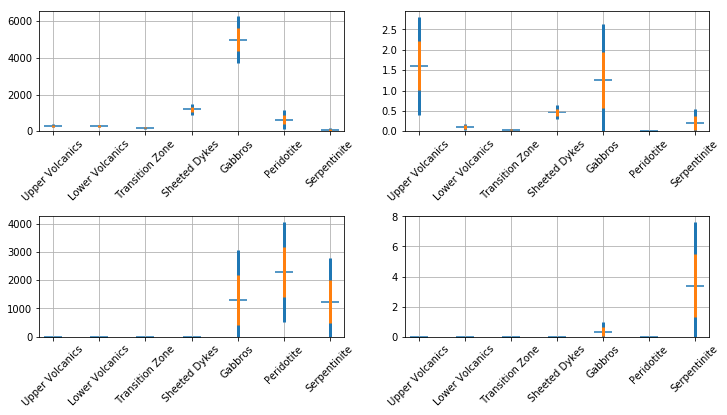

In [29]:
fig, axs = plt.subplots(2,2, figsize=(12, 6))
fig.subplots_adjust(hspace = 0.7, wspace = 0.2)
axs = axs.ravel()

for ind, (i,j) in enumerate(zip(means, SDs)):
    axs[ind].scatter(X,i, marker='_', s=300)
    axs[ind].errorbar(X,i[0],[k*2 for k in j[0]], ls='none', lw=3)
    axs[ind].errorbar(X,i[0],j[0], ls='none', lw=3)

for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=45)
    plt.ylim(0)
    plt.grid()
#plt.savefig('%sComparison.pdf' % savedir)

In [31]:
#we can also plot other stuff to see how everything is related

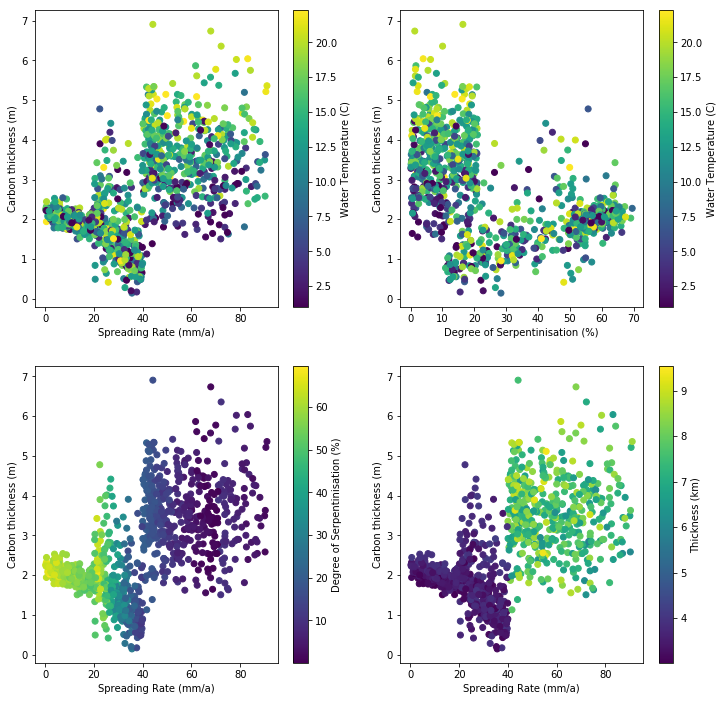

In [56]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(nrows=2,ncols=2, figsize=(12,12))
plt11 = ax11.scatter(SR_key, C_results[:,0]*1000, c=np.asarray(water_tmp))
ax11.set_xlabel('Spreading Rate (mm/a)')
ax11.set_ylabel('Carbon thickness (m)')
cbar11 = fig.colorbar(plt11, ax=ax11)
cbar11.set_label('Water Temperature (C)')

plt12 = ax12.scatter(DS_key, C_results[:,0]*1000, c=np.asarray(water_tmp))
ax12.set_xlabel('Degree of Serpentinisation (%)')
ax12.set_ylabel('Carbon thickness (m)')
cbar12 = fig.colorbar(plt12, ax=ax12)
cbar12.set_label('Water Temperature (C)')

plt21 = ax21.scatter(SR_key, C_results[:,0]*1000, c=DS_key)
ax21.set_xlabel('Spreading Rate (mm/a)')
ax21.set_ylabel('Carbon thickness (m)')
cbar21 = fig.colorbar(plt21, ax=ax21)
cbar21.set_label('Degree of Serpentinisation (%)')

plt22 = ax22.scatter(SR_key, C_results[:,0]*1000, c=thick_key[:,0])
ax22.set_xlabel('Spreading Rate (mm/a)')
ax22.set_ylabel('Carbon thickness (m)')
cbar22 = fig.colorbar(plt22, ax=ax22)
cbar22.set_label('Thickness (km)')